In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt,mean,log,diff
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # https://github.com/ranaroussi/yfinance
import pickle
import torch # seems to be necessary to enable keras GPU usage
import tensorflow as tf
from tensorflow import keras

This notebook uses a Long Short-Term Memory (LSTM) network to predict stock prices along the lines of Moghar et al., Procedia Computer Science 170, 1168 (2020). It uses historic stock price data from Yahoo Finance.

In [2]:
tickers_list = ['AAPL', 'WMT', 'IBM', 'TSLA']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,'2017-1-1')['Adj Close']
idx = data.index

# Print first 5 rows of the data
print(data.tail())

[*********************100%***********************]  4 of 4 completed
                  AAPL         IBM        TSLA         WMT
Date                                                      
2020-11-23  113.849998  120.089996  521.849976  150.929993
2020-11-24  115.169998  124.419998  555.380005  151.360001
2020-11-25  116.029999  124.199997  574.000000  151.830002
2020-11-27  116.589996  124.349998  585.760010  151.600006
2020-11-30  118.851997  124.470001  580.000000  151.078705


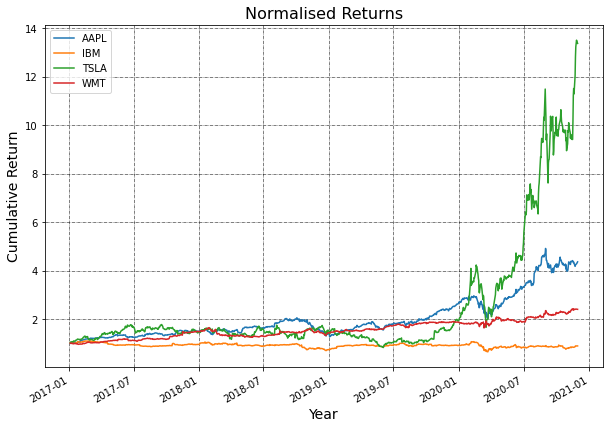

In [3]:
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Normalised Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [4]:
def getTimelagDataset(data, lag=60, forecast=5): # takes a numpy array, returns time lagged training data
    X, y, X_last = [], [], []
    for i in range(lag, data.shape[0]-forecast):
        X.append(data[i-lag:i, 0])
        y.append(data[i:i+forecast, 0])
        
    X, y = np.array(X), np.array(y)
    X    = np.reshape(X, (X.shape[0], X.shape[1], 1)) # one feature (price)
    
    return X, y

In [5]:
stockname = "TSLA"
lag = 60
n_forecast = 5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data[[stockname]])
X, y = getTimelagDataset(data, lag, n_forecast)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def LSTMmodel(n_forecast): # model from Moghar et al.
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=n_forecast))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
model = LSTMmodel(n_forecast)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

with tf.device('/device:GPU:0'):
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[earlyStopping])

Train on 736 samples, validate on 184 samples
Epoch 1/50
736/736 [==============================] - 14s 19ms/sample - loss: 0.0011 - val_loss: 0.0072
Epoch 2/50
736/736 [==============================] - 1s 1ms/sample - loss: 3.7652e-04 - val_loss: 0.0074
Epoch 3/50
736/736 [==============================] - 1s 1ms/sample - loss: 4.3516e-04 - val_loss: 0.0075
Epoch 4/50
736/736 [==============================] - 1s 1ms/sample - loss: 3.3448e-04 - val_loss: 0.0270
Epoch 5/50
736/736 [==============================] - 1s 1ms/sample - loss: 3.1813e-04 - val_loss: 0.0128
Epoch 6/50
736/736 [==============================] - 1s 1ms/sample - loss: 3.1148e-04 - val_loss: 0.0218
Epoch 7/50
736/736 [==============================] - 1s 1ms/sample - loss: 2.9885e-04 - val_loss: 0.0109
Epoch 8/50
736/736 [==============================] - 1s 1ms/sample - loss: 2.6771e-04 - val_loss: 0.0121
Epoch 9/50
736/736 [==============================] - 1s 1ms/sample - loss: 2.2531e-04 - val_loss: 0.0158
Ep

In [8]:
X_test = X[int(-0.2*X.shape[0]):]
y_pred = model.predict(X_test)
y_pred, y = scaler.inverse_transform(y_pred), scaler.inverse_transform(y)

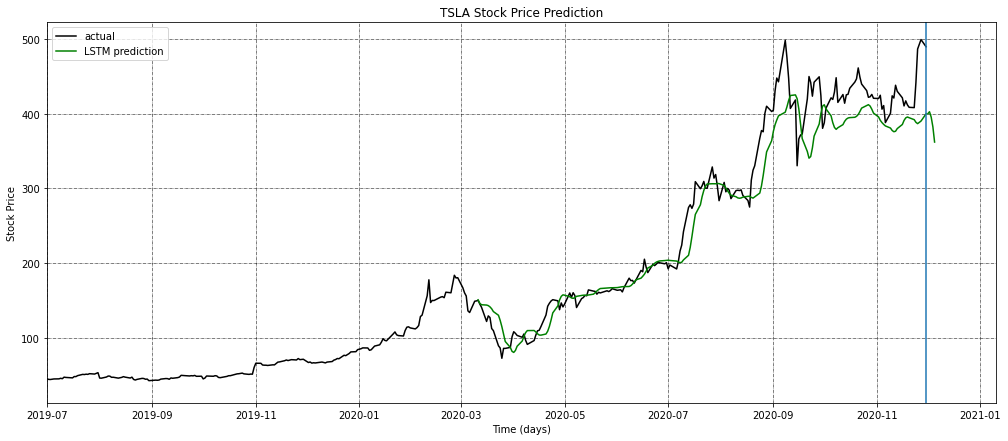

In [10]:
plt.plot(idx[-len(y[:,0]):],      y[:,0],      color='black', label='actual')
plt.plot(idx[-len(y_pred[:,0]):], y_pred[:,0], color='green', label='LSTM prediction')

# continue idx by lag - assume date format
from datetime import datetime, timedelta, date
startdate = idx[-1]
idx_forecast = idx.copy(deep=True)
for i in range(n_forecast):
    idx_forecast = idx_forecast.append(pd.Index([startdate+timedelta(days=i+1)]))

plt.plot(idx_forecast[-len(y_pred[-1]):], y_pred[-1], color='green')
plt.title(stockname+' Stock Price Prediction')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlim(date(2019, 7, 1), date(2021, 1, 10))
plt.axvline(x=startdate)
plt.legend()
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.gcf().set_size_inches(17, 7)
plt.show()
plt.close()